In [1]:
!pip install optuna

In [1]:
from utils import *
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import xgboost as xgb
import optuna
from optuna import TrialPruned
from utils import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import json

c:\Users\Pablo\anaconda3\envs\proyecto_keepcoding\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_Stress = pd.read_excel("Copia de Behavioral-features - per minute.xlsx")

In [3]:
df_Stress.head(10)

,PP,Blok,Condition,timestamp,Valence_rc,Arousal_rc,Dominance,Stress,MentalEffort,MentalDemand,...,WristLeft_HandLeftPlaneYZAxisZstdv,ShoulderRight_ElbowRightPlaneZXAxisXstdv,ShoulderRight_ElbowRightPlaneXYAxisYstdv,ShoulderRight_ElbowRightPlaneYZAxisZstdv,ElbowRight_WristRightPlaneZXAxisXstdv,ElbowRight_WristRightPlaneXYAxisYstdv,ElbowRight_WristRightPlaneYZAxisZstdv,WristRight_HandRightPlaneZXAxisXstdv,WristRight_HandRightPlaneXYAxisYstdv,WristRight_HandRightKinectZAxisstdv
0,PP1,1,R,20120918T131600000,NaN,NaN,NaN,NaN,NaN,NaN,...,166.872086,22.946337,5.605230,13.237048,30.932939,102.460262,8.444481,54.436879,75.886750,155.734343
1,PP1,1,R,20120918T131700000,NaN,NaN,NaN,NaN,NaN,NaN,...,58.237714,7.194860,2.468881,3.886001,2.000359,3.431337,1.160298,4.579341,2.868843,171.486911
2,PP1,1,R,20120918T131800000,NaN,NaN,NaN,NaN,NaN,NaN,...,64.548824,14.726365,2.953021,9.185623,13.379140,48.162012,30.508877,23.013755,30.629061,149.748809
3,PP1,1,R,20120918T131900000,NaN,NaN,NaN,NaN,NaN,NaN,...,38.209895,2.542686,1.564318,2.453674,4.796273,8.223865,1.114906,3.854074,4.048611,173.149430
4,PP1,1,R,20120918T132000000,NaN,NaN,NaN,NaN,NaN,NaN,...,80.171422,9.905241,20.342488,5.552234,7.198096,22.942488,46.386278,17.514534,29.702675,165.368301
5,PP1,1,R,20120918T132100000,NaN,NaN,NaN,NaN,NaN,NaN,...,98.907746,7.748967,1.058581,5.632123,6.953512,5.591442,3.735698,30.137148,57.577431,151.554940
6,PP1,1,N,20120918T132600000,6.0,4.0,6.0,4.1,5.1,0.7,...,81.208417,2.193391,2.353367,1.800807,3.298600,5.711348,65.979538,26.049338,123.564767,36.918869
7,PP1,1,N,20120918T132700000,6.0,4.0,6.0,4.1,5.1,0.7,...,155.183912,9.271625,8.185302,4.089097,6.906731,9.327650,76.878457,28.215609,107.462005,105.295347
8,PP1,1,N,20120918T132800000,6.0,4.0,6.0,4.1,5.1,0.7,...,53.912808,19.278932,2.330069,8.432293,19.630151,58.211049,98.285955,23.155413,99.189884,161.392789
9,PP1,1,N,20120918T132900000,6.0,4.0,6.0,4.1,5.1,0.7,...,21.500961,4.079656,1.618863,0.916299,4.096824,30.095558,149.907085,24.848498,89.450385,142.564028


In [4]:
# Hago una copia del dataframe para no modificar el original
df_stress = df_Stress.copy()
#Eliminamos columnas que no son compatibles con nuestro problema ya que no tendremos esas features en nuestro datos de entrada de nuestra APP
columnas_a_eliminar = ['PP','timestamp','HR','RMSSD', 'RMSSD','SCL','Valence_rc','Arousal_rc',
                       'Dominance','MentalEffort','MentalDemand','PhysicalDemand','TemporalDemand',
                       'Effort','Performance_rc','Frustration','NasaTLX','Squality','Sneutral','Shappy',
                       'Ssad','Sangry','Ssurprised','Sscared','Sdisgusted','Svalence']
df_stress = df_stress.drop(columnas_a_eliminar, axis=1)
#Filtramos filas que tengan condición diferente a 'R'
df_stress = df_stress[df_stress['Condition'] != 'R']
#Convierto variable Stress a int
df_stress['Stress'] = df_stress['Stress'].astype(int)
#Dividimos los datos : voy a estrtificar por condition
X = df_stress.drop('Stress', axis=1)
y = df_stress['Stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=df_stress['Condition']) # probar con stratify = 'Blok'
# Variables categóricas
categorical_features = ['Condition','Blok']
#convertir en categoricas
X_train[categorical_features] = X_train[categorical_features].astype('category')
#Aplicamos one hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_features)
# Variables numéricas
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Imputación de valores nulos
imputer = SimpleImputer(strategy='most_frequent') # probar con media
#Entrenamos el imputer
imputer.fit(X_train[numeric_features])
#Aplicamos la transformación
X_train[numeric_features] = imputer.transform(X_train[numeric_features])
# Normalización
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
# matriz de correlación
corr = X_train.corr().abs()
# Seleccionar las columnas con correlación > 0.8 (excepto la diagonal)
high_corr_cols = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if corr.iloc[i, j] > 0.8:
            colname = corr.columns[i]
            high_corr_cols.add(colname)
# Eliminar las columnas redundantes en X_train
X_train.drop(columns=high_corr_cols, inplace=True)
print(f"Eliminadas {len(high_corr_cols)} columnas altamente correlacionadas entre sí (sin considerar 'Stress').")
print(f"Columnas eliminadas: {list(high_corr_cols)}")

# Aplicamos las mismas transformaciones a X_test
X_test[categorical_features] = X_test[categorical_features].astype('category')
X_test = pd.get_dummies(X_test, columns=categorical_features)
X_test[numeric_features] = imputer.transform(X_test[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
X_test.drop(columns=high_corr_cols, inplace=True)



Eliminadas 43 columnas altamente correlacionadas entre sí (sin considerar 'Stress').
Columnas eliminadas: ['ShoulderCenter_HeadPlaneXYAxisYavg', 'Spine_ShoulderCenterShoulderCenter_ShoulderRightavg', 'SnChars', 'ElbowRight_WristRightWristRight_HandRightavg', 'SrightEyeClosed', 'ShoulderCenter_HeadPlaneYZAxisZavg', 'ShoulderRight_ElbowRightPlaneZXAxisXavg', 'Spine_ShoulderCenterPlaneYZAxisZavg', 'Spine_ShoulderCenterShoulderCenter_Headavg', 'Spine_ShoulderCenterPlaneYZAxisZstdv', 'ShoulderCenter_ShoulderRightPlaneXYAxisYavg', 'HipCenter_SpinePlaneXYAxisYavg', 'ShoulderCenter_ShoulderRightPlaneXYAxisYstdv', 'WristLeft_HandLeftPlaneZXAxisXavg', 'WristLeft_HandLeftPlaneXYAxisYavg', 'HipCenter_SpinePlaneYZAxisZstdv', 'SnSpecialKeys', 'SnDragged', 'Spine_ShoulderCenterShoulderCenter_ShoulderLeftstdv', 'SAu10_UpperLipRaiser', 'SnSpaces', 'SnLeftClicked', 'SAu43_EyesClosed', 'HipCenter_SpinePlaneZXAxisXavg', 'Blok_1', 'WristRight_HandRightPlaneZXAxisXavg', 'ShoulderCenter_ShoulderLeftShoulderL

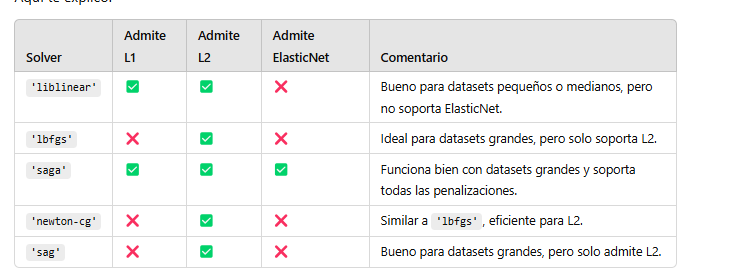

In [5]:
import optuna
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from optuna.exceptions import TrialPruned

def objective(trial):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        #'C': trial.suggest_float('C', 1e-4, 10.0, log=True),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000, step=500),
        #'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        #'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        #'tol': trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    }

    # Validar combinaciones de solver y penalty
    if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
        return float("nan")
    if params['penalty'] == 'elasticnet' and params['solver'] != 'saga':
        return float("nan")
    if params['penalty'] is None and params['solver'] == 'liblinear':
        return float("nan")

    model = LogisticRegression(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    try:
        scores = []
        for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
            X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]
            model.fit(X_t, y_t)
            val_score = model.score(X_v, y_v)
            scores.append(val_score)
            trial.report(val_score, fold)

            if trial.should_prune():
                raise TrialPruned()

        return np.mean(scores)

    except Exception as e:
        print(f"Error con los parámetros: {params}, Error: {e}")
        return float("nan")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)



[I 2025-03-26 23:38:32,490] A new study created in memory with name: no-name-33ee07d8-2808-4ed8-9c75-41c9af6587ea
[I 2025-03-26 23:38:36,574] Trial 0 finished with value: 0.6837209302325581 and parameters: {'penalty': None, 'solver': 'lbfgs', 'max_iter': 3000}. Best is trial 0 with value: 0.6837209302325581.
[I 2025-03-26 23:38:39,427] Trial 1 finished with value: 0.7255813953488371 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 2000}. Best is trial 1 with value: 0.7255813953488371.
[W 2025-03-26 23:38:39,434] Trial 2 failed with parameters: {'penalty': 'elasticnet', 'solver': 'liblinear', 'max_iter': 1000} because of the following error: The value nan is not acceptable.
[W 2025-03-26 23:38:39,434] Trial 2 failed with value nan.
[I 2025-03-26 23:38:43,310] Trial 3 finished with value: 0.6837209302325581 and parameters: {'penalty': None, 'solver': 'lbfgs', 'max_iter': 4000}. Best is trial 1 with value: 0.7255813953488371.
[I 2025-03-26 23:38:47,178] Trial 4 finishe

In [8]:
# Evaluación del modelo
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression(**study.best_params)
model.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# metricas en entrenamiento
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')
precision_score_train = precision_score(y_train, y_train_pred, average='weighted')
recall_score_train = recall_score(y_train, y_train_pred, average='weighted')
# metricas en test
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')
precision_score_test = precision_score(y_test, y_test_pred, average='weighted')
recall_score_test = recall_score(y_test, y_test_pred, average='weighted')

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Informe de clasificación
print("\nClassification Report - Train")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test")
print(classification_report(y_test, y_test_pred))

# Overfit gap
overfit_gap = train_acc - test_acc
print(f"\nOverfit Gap: {overfit_gap:.4f}")

Train Accuracy: 0.8637
Test Accuracy: 0.7677

Classification Report - Train
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       263
           1       0.82      0.81      0.82       386
           2       0.85      0.85      0.85       529
           3       0.79      0.81      0.80       262
           4       0.89      0.90      0.90       261
           5       0.90      0.92      0.91       168
           6       0.97      0.97      0.97       129
           7       0.98      0.96      0.97       114
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        21

    accuracy                           0.86      2150
   macro avg       0.91      0.91      0.91      2150
weighted avg       0.86      0.86      0.86      2150


Classification Report - Test
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        63
           1       0.65   

In [9]:
# columnas de X_train
X_train_columns = X_train.columns
X_train_columns

Index(['SyHeadOrientation', 'SxHeadOrientation', 'SzHeadOrientation',
       'SmouthOpen', 'SleftEyeClosed', 'SleftEyebrowLowered',
       'SleftEyebrowRaised', 'SrightEyebrowLowered', 'SrightEyebrowRaised',
       'SgazeDirectionForward',
       ...
       'ElbowRight_WristRightPlaneXYAxisYstdv',
       'ElbowRight_WristRightPlaneYZAxisZstdv',
       'WristRight_HandRightPlaneZXAxisXstdv',
       'WristRight_HandRightPlaneXYAxisYstdv',
       'WristRight_HandRightKinectZAxisstdv', 'Condition_I', 'Condition_N',
       'Condition_T', 'Blok_2', 'Blok_3'],
      dtype='object', length=107)

In [10]:


# Guardar el modelo en un archivo .pkl
with open("modelo_Regresión_logísitica.pkl", "wb") as f:
    pickle.dump(model, f)

# Guardar los parámetros y métricas en un archivo JSON
model_info = {
    "best_params": study.best_params,
    "train_metrics": {
        "accuracy": train_acc,
        "f1_score": f1_score_train,
        "precision": precision_score_train,
        "recall": recall_score_train
    },
    "test_metrics": {
        "accuracy": test_acc,
        "f1_score": f1_score_test,
        "precision": precision_score_test,
        "recall": recall_score_test
    },
    "overfit_gap": overfit_gap
}

with open("metricas_y_best_params_RegresiónLogística.json", "w") as f:
    json.dump(model_info, f, indent=4)

# Guardar las columnas de X_train en un archivo txt
with open("columnas_X_train_RegresiónLogística.txt", "w") as f:
    f.write("\n".join(X_train_columns))

print("\nModelo y parámetros guardados correctamente.")



Modelo y parámetros guardados correctamente.


Estos son recomendaciones de chatGPT, no hacerle caso

Aumentar el min_samples_leaf → Subirlo a 7-10 evitará que los árboles se vuelvan demasiado específicos.
Reducir max_depth a 6 o 7 → Un árbol menos profundo generaliza mejor.
Aumentar min_impurity_decrease → Subirlo a 0.05-0.07 para podar ramas irrelevantes.
Agregar Dropout o Regularización → Usar class_weight='balanced' puede ayudar si hay clases desbalanceadas.
Más datos de entrenamiento → Si es posible, aumentar el dataset con data augmentation o técnicas de síntesis de datos.
Ajustar max_samples → Disminuirlo a 0.5-0.55 para forzar más diversidad en los árboles.

In [11]:
df_resultados = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_pred})

display(df_resultados)

,y_test,y_pred
2869,5,5
3126,0,0
1373,2,1
742,3,3
1603,1,1
...,...,...
488,4,4
2201,4,4
1458,7,7
2540,2,7
